# Sign Language Detection

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

## First Dataset

In [ ]:
!curl -L -o dataset-sign.zip "https://drive.usercontent.google.com/download?id=101vuY4B474fMy9C_derEIxAVxd2ARc9U&authuser=0&confirm=t&uuid=6a6ac8c3-7881-4834-a58e-0cc7ae1ee7f4&at=AENtkXaM-csHzbMhZl547eqBHlvq%3A1732197046359"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1050M  100 1050M    0     0  41.9M      0  0:00:25  0:00:25 --:--:-- 63.7M


In [ ]:
%%capture
!unzip dataset-sign.zip

In [ ]:
import tensorflow as tf

def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=64):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.cache().prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.cache().prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

# Example usage
train_dir = "dataset-sign/train"
val_dir = "dataset-sign/val"

train_dataset, validation_dataset = load_datasets(train_dir, val_dir)

# Check the output
for image_batch, labels_batch in train_dataset:
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 78300 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Image batch shape: (64, 128, 128, 3)
Labels batch shape: (64, 29)


In [ ]:
# For baseline model purposes, we will only use subset of the data,
# each folder class only contain 100 images on training and 50 images on validation
# create a folder train_subset and validation_subset
# TRAIN_SUBSET_DIR = '../data/train_subset'
# VALIDATION_SUBSET_DIR = '../data/validation_subset'

import os
import random
import shutil

def create_train_val_subsets(data_dir, subset_train_dir, subset_val_dir, num_images_train, num_images_val):
    if not os.path.exists(subset_train_dir):
        os.makedirs(subset_train_dir)
    if not os.path.exists(subset_val_dir):
        os.makedirs(subset_val_dir)

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        train_folder_path = os.path.join(subset_train_dir, folder)
        val_folder_path = os.path.join(subset_val_dir, folder)

        if not os.path.exists(train_folder_path):
            os.makedirs(train_folder_path)
        if not os.path.exists(val_folder_path):
            os.makedirs(val_folder_path)

        files = os.listdir(folder_path)
        random.shuffle(files)

        train_files = files[:num_images_train]
        val_files = files[num_images_train:num_images_train + num_images_val]

        for file in train_files:
            shutil.copy(os.path.join(folder_path, file), os.path.join(train_folder_path, file))

        for file in val_files:
            shutil.copy(os.path.join(folder_path, file), os.path.join(val_folder_path, file))

num_images_train = 100
num_images_val = 50

# create_train_val_subsets(ORIGINAL_TRAIN_DIR, TRAIN_SUBSET_DIR, VALIDATION_SUBSET_DIR, num_images_train, num_images_val)

Let's take a look at what the images look like.

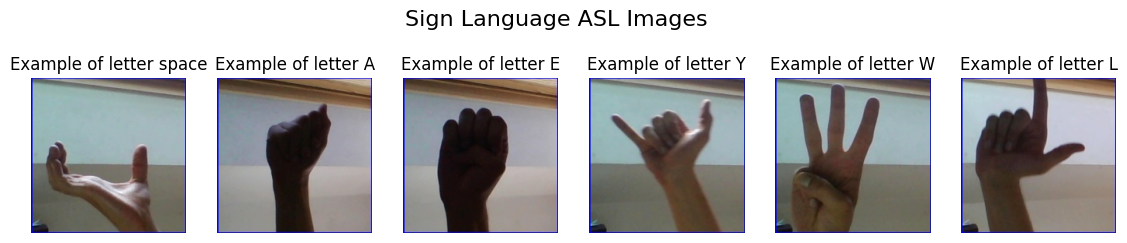

In [ ]:
# Plot one image from the first 4 letters
def plot_images(data_dir):
    fig, axes = plt.subplots(1, 6, figsize=(14, 3))
    fig.suptitle('Sign Language ASL Images', fontsize=16)
    for ii, letter in enumerate(['space','A' , 'E', 'Y', 'W', 'L']):
        letter_dir = f'{data_dir}/{letter}'
        img = tf.keras.preprocessing.image.load_img(letter_dir+'/'+letter+'10.jpg')
        axes[ii].imshow(img)
        axes[ii].set_title(f'Example of letter {letter}')
        axes[ii].axis('off')
    plt.show()
    return img
img = plot_images("/content/dataset-sign/train/")

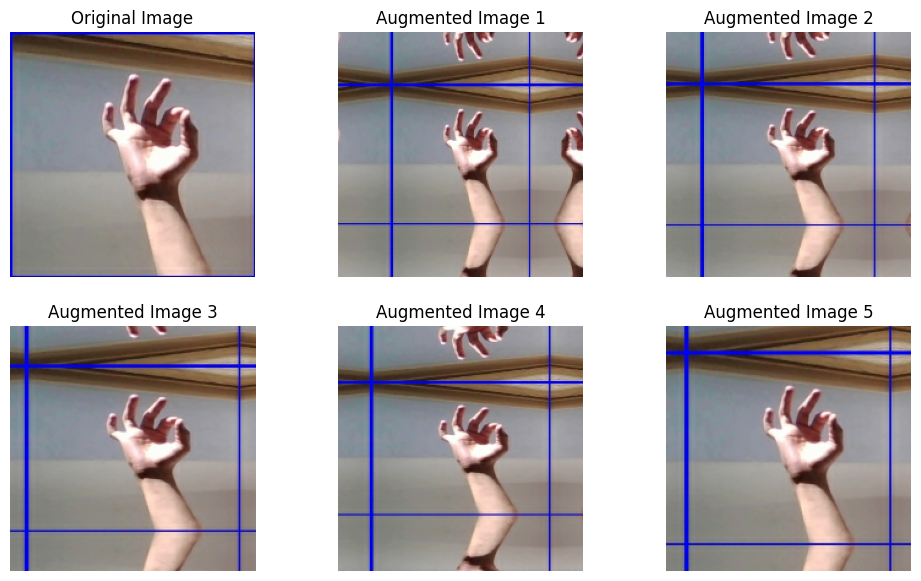

In [ ]:
# Random zoom the data
image_path = "/content/dataset-sign/train/F/F364.jpg"
hw_factor = (1, 0.0)
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  # tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomZoom(height_factor=hw_factor, width_factor=hw_factor),
])

# Load the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(12, 7))

# Plot original image
ax = plt.subplot(2, 3, 1)
plt.imshow(image.numpy())
plt.title("Original Image")
plt.axis("off")

# Plot augmented images
for i in range(5):
  augmented_image = data_augmentation(tf.expand_dims(image, 0))
  ax = plt.subplot(2, 3, i + 2)
  plt.imshow(tf.squeeze(augmented_image).numpy())
  plt.title(f"Augmented Image {i+1}")
  plt.axis("off")

plt.show()

done
--- 0.13034582138061523 seconds ---


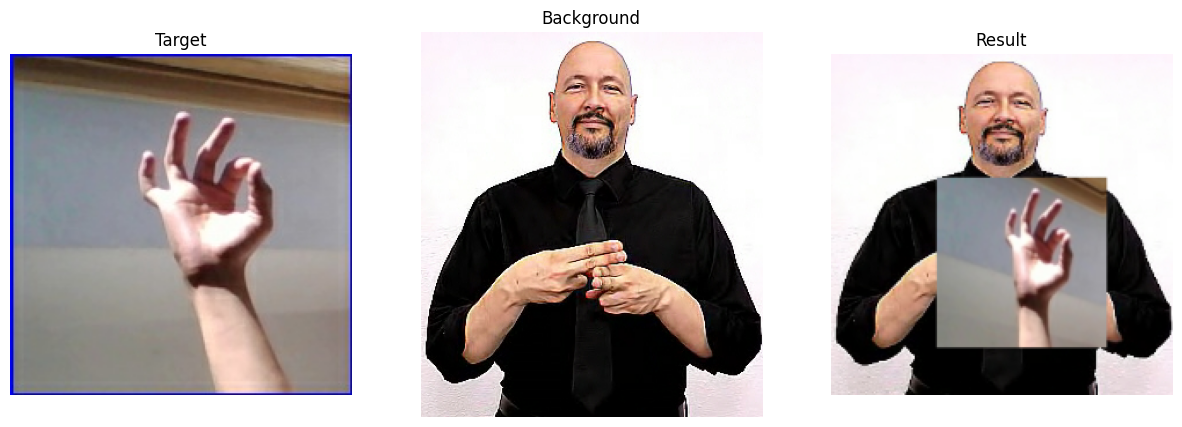

Shape of the result image: (200, 200, 3)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


def add_image_with_transform(
    image_target_path, image_background_path, reduced_factor,
    translate_x=0, translate_y=0, rotate_factor=0.2
):
    """
    Places a target image at the center of a background image with resizing, translation, and rotation.

    Args:
        image_target_path (str): Path to the target image (foreground).
        image_background_path (str): Path to the background image.
        reduced_factor (float): Scaling factor for the target image (0 < reduced_factor <= 1).
        translate_x (int): Horizontal translation in pixels (positive for right, negative for left).
        translate_y (int): Vertical translation in pixels (positive for down, negative for up).
        rotate_angle (float): Rotation angle in degrees (clockwise).

    Returns:
        tf.Tensor: Combined image with the target image transformed and overlaid on the background.
    """
    if not (0 < reduced_factor <= 1):
        raise ValueError("reduced_factor must be between 0 and 1.")

    # Load the background and target images
    background_image = tf.image.decode_image(tf.io.read_file(image_background_path))
    target_image = tf.image.decode_image(tf.io.read_file(image_target_path))

    # Ensure images are in float32 and scaled between 0 and 1
    background_image = tf.image.convert_image_dtype(background_image, tf.float32)
    target_image = tf.image.convert_image_dtype(target_image, tf.float32)

    # Get dimensions of the background image
    bg_height, bg_width, _ = background_image.shape

    # Calculate the new dimensions for the target image
    new_height = int(bg_height * reduced_factor)
    new_width = int(bg_width * reduced_factor)

    # crop and resize the target image
    target_image = tf.image.central_crop(target_image, 0.9)

    # apply keras layers augmentation
    data_augmentation = tf.keras.Sequential([
        # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(rotate_factor),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    ])

    # augment the image
    target_image = data_augmentation(tf.expand_dims(target_image, 0))
    target_image = tf.squeeze(target_image)

    # Apply scaling
    target_image = tf.image.resize(target_image, (new_height, new_width))

    # Create a blank canvas the same size as the background
    canvas = tf.zeros_like(background_image)

    # Calculate offsets to center the target image on the canvas, with translations
    offset_height = (bg_height - new_height) // 2 + translate_y
    offset_width = (bg_width - new_width) // 2 + translate_x

    # Ensure offsets are within bounds
    offset_height = max(0, min(offset_height, bg_height - new_height))
    offset_width = max(0, min(offset_width, bg_width - new_width))

    # Overlay the resized and rotated target image onto the background
    canvas = tf.tensor_scatter_nd_update(
        canvas,
        indices=[[y + offset_height, x + offset_width, c]
                 for y in range(target_image.shape[0])
                 for x in range(target_image.shape[1])
                 for c in range(3)],
        updates=tf.reshape(target_image, [-1])
    )

    # Combine the target image with the background image
    combined_image = tf.where(canvas > 0, canvas, background_image)
    # resize the image to 200x200
    combined_image = tf.image.resize(combined_image, (200, 200))
    print("done")
    return combined_image


# Example usage
background_path = "sign_person.jpg"
target_path = "F364.jpg"
scaling_factor = 0.5
translate_x = random.randint(-30, 30)
translate_y = 25 + random.randint(0, 30)
import time
start_time = time.time()
result_image = add_image_with_transform(
    target_path, background_path, scaling_factor,
    translate_x=translate_x, translate_y=translate_y
)
print("--- %s seconds ---" % (time.time() - start_time))

# Plot the result
def plot_images(target_path, background_path, result_image):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display the target and background images
    for i, path in enumerate([target_path, background_path]):
        img = tf.image.decode_image(tf.io.read_file(path))
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title("Target" if i == 0 else "Background")

    axes[2].imshow(result_image)
    axes[2].axis("off")
    axes[2].set_title("Result")

    plt.show()

    # Print the shape of the result image
    print("Shape of the result image:", result_image.shape)

plot_images(target_path, background_path, result_image)

# full_data_augmentation = tf.keras.Sequential([


In [ ]:
# Convert the image into its numpy array representation
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (200, 200, 3)


In [ ]:
sample_array[0,:5]

array([[  0.,   5., 247.],
       [  0.,   0., 244.],
       [  8.,   0., 248.],
       [  7.,   0., 248.],
       [  1.,   0., 251.]], dtype=float32)

### Creating the datasets

In [ ]:
def train_val_datasets():
    """Create train and validation datasets

    Returns:
        (tf.data.Dataset, tf.data.Dataset): train and validation datasets
    """
    ### START CODE HERE ###
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=validation_data_dir,
        batch_size=32,
        image_size=(200,200),
		label_mode='categorical',
        # Use this argument to get just one color dimension, because it is greyscale
        color_mode = "grayscale",
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=train_data_dir,
        batch_size=32,
        image_size=(200,200),
		label_mode='categorical',
        # Use this argument to get just one color dimension, because it imgs are greyscale
        color_mode = "grayscale",
    )
    ### END CODE HERE ###

    return train_dataset, validation_dataset

In [ ]:
# Create train and validation datasets
# train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Found 2900 files belonging to 29 classes.
Found 1450 files belonging to 29 classes.
Images of train dataset have shape: (None, 200, 200, 1)
Labels of train dataset have shape: (None, 29)
Images of validation dataset have shape: (None, 200, 200, 1)
Labels of validation dataset have shape: (None, 29)


## Base Model

In [ ]:
# display the label and the sum of it
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy().sum(axis=0))
    break

(64, 128, 128, 3)
(64, 29)
[2. 0. 1. 2. 4. 2. 1. 4. 1. 1. 4. 4. 2. 3. 3. 3. 2. 2. 3. 4. 3. 1. 2. 3.
 3. 1. 1. 1. 1.]


In [ ]:
# GRADED FUNCTION: create_model
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])
def create_model():
    """Create the classifier model

    Returns:
        tf.keras.model.Sequential: CNN for multi-class classification
    """
    ### START CODE HERE ###

    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
        # Define an input layer
        tf.keras.Input(shape=(128,128,3)), # Set correct input size
        # Rescale images
        # data_augmentation,
        tf.keras.layers.Rescaling(1./255),

        # This is the first convolution
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # The second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # The third convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(29, activation='softmax')

        ])

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ### END CODE HERE ###
    return model

In [ ]:
# Create your model
model = create_model()

print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 128, 128, 3)
Output shape: (None, 29)


In [ ]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 63, 63, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │         200,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 29)                  │             957 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,477 (845.61 KB)

 Trainable params: 216,253 (844.74 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
with tf.device('/GPU:0'):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
  history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15, callbacks=[callback])

Epoch 1/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.2963 - loss: 2.4559 - val_accuracy: 0.4121 - val_loss: 1.8582
Epoch 2/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6434 - loss: 1.1174 - val_accuracy: 0.7147 - val_loss: 0.8709
Epoch 3/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7421 - loss: 0.7829 - val_accuracy: 0.7409 - val_loss: 0.8247
Epoch 4/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7912 - loss: 0.6237 - val_accuracy: 0.8015 - val_loss: 0.5932
Epoch 5/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8201 - loss: 0.5310 - val_accuracy: 0.6545 - val_loss: 1.2635
Epoch 6/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8414 - loss: 0.4689 - val_accuracy: 0.8493 - val_loss: 0.4471
Epoch 7/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8570 - loss: 0.4207 - val_accuracy: 0.5589 - val_loss: 1.8135
Epoch 8/15
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8687 -

In [ ]:
model.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9416 - loss: 0.2222


[0.3147243559360504, 0.9048275947570801]

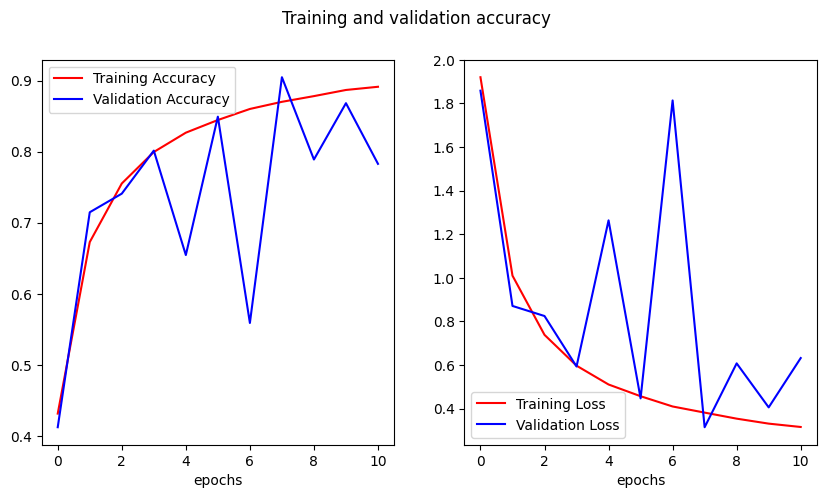

Train accuracy: 0.8914
Train loss: 0.3158
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9416 - loss: 0.2222


In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

# print the model accuracy and loss both training and validation from the last history epoch
print(f"Train accuracy: {acc[-1]:.4f}")
print(f"Train loss: {loss[-1]:.4f}")
model.evaluate(validation_dataset)

model.save('base_model.keras')

In [ ]:
# load from base_model.keras
model_base = tf.keras.models.load_model('sign_language_base_model.keras')
model_base.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9416 - loss: 0.2222


[0.314724326133728, 0.9048275947570801]

In [ ]:
model = tf.keras.models.load_model('sign_language_model_v1.keras')
model.evaluate(validation_dataset)

136/136 ━━━━━━━━━━━━━━━━━━━━ 151s 973ms/step - accuracy: 0.9875 - loss: 0.0499


[0.050716646015644073, 0.9871264100074768]

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image_class(image_path, model, class_names, show=False):
    """Predict the class of a single image

    Args:
        image_path (str): Path to the image file
        model (tf.keras.models.Model): Trained model
        class_names (list): List of class names

    Returns:
        str: Predicted class
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, (128, 128))
    img_array = tf.expand_dims(img_array, 0)  # Expand dims to create batch axis

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and the predicted class
    print(f"Predicted: {predicted_class} ({image_path})")
    if show:
      plt.imshow(img)
      plt.title(f"Predicted: {predicted_class} ({image_path})")
      plt.axis('off')
      plt.show()

    return predicted_class, np.argmax(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: W (dataset-sign/train/W/W10.jpg)


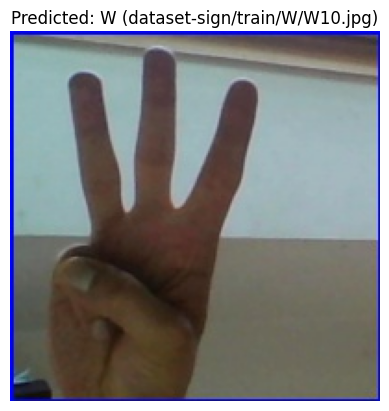

('W', 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: W (dataset-sign/train/W/W10.jpg)
('W', 22)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: Q (L.jpg)


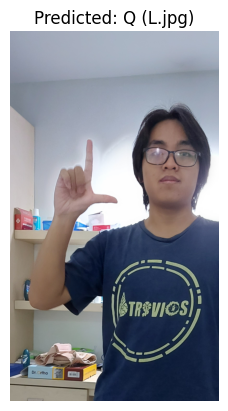

('Q', 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted: F (L.jpg)
('F', 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted: Q (W.jpg)


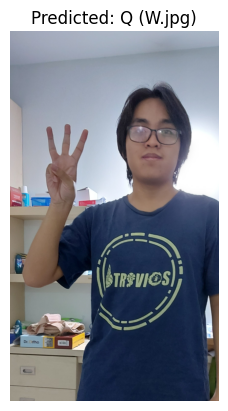

('Q', 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: F (W.jpg)
('F', 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted: L (L2.png)


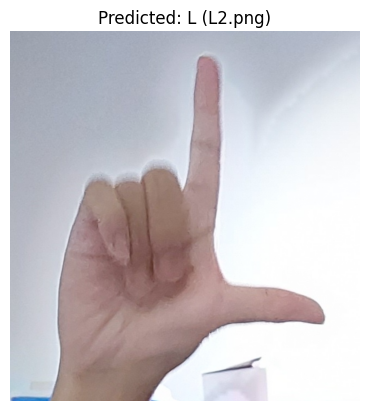

('L', 11)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted: L (L2.png)
('L', 11)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted: R (we.png)


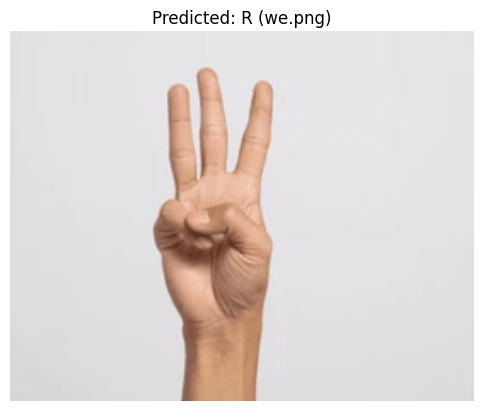

('R', 17)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: E (we.png)
('E', 4)


In [ ]:
# Example usage:
# class_names = ['class1', 'class2', 'class3']  # Replace with actual class names
# Ensure 'model' is defined and compatible with the input shape (200, 200, 3)
path = "dataset-sign/train/W/W10.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "L.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "W.jpg"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "L2.png" # ini setelah di zoom
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))
print()
path = "we.png"
print(predict_image_class(path, model_base, class_names, True))
print(predict_image_class(path, model, class_names))

## New data

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d debashishsau/aslamerican-sign-language-aplhabet-dataset

Dataset URL: https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset
License(s): CC0-1.0
100% 4.20G/4.20G [03:16<00:00, 23.0MB/s]
100% 4.20G/4.20G [03:16<00:00, 22.9MB/s]


In [ ]:
! unzip "aslamerican-sign-language-aplhabet-dataset"

Streaming output truncated to the last 5000 lines.
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2871).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2872).jpg  
  inflating: ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2873).jpg  
  inflating: A

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=128):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.cache().prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.cache().prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

In [ ]:
train_asl_dir = 'ASL_Alphabet_Dataset/asl_alphabet_train'
train_asl, _ = load_datasets(train_asl_dir)

Found 223074 files belonging to 29 classes.


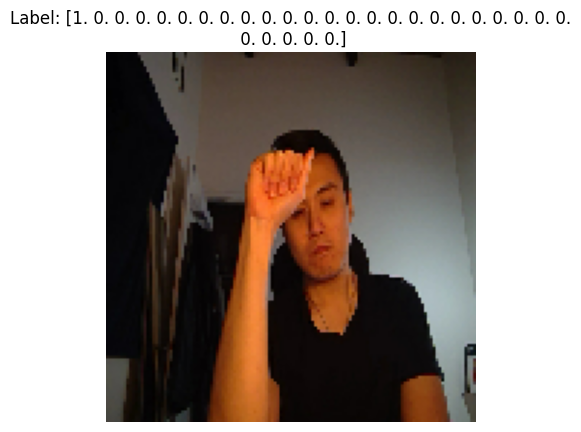

In [ ]:
import matplotlib.pyplot as plt

for image_batch, label_batch in train_asl.take(100010):
    plt.imshow(image_batch[0].numpy())
    plt.title(f"Label: {label_batch[0].numpy()}")
    plt.axis("off")
    plt.show()
    break

In [ ]:
model = tf.keras.models.load_model('sign_language_model_v1.keras')

In [ ]:
# shuffle_data = train_asl.shuffle(223074)
sub_data = train_asl.take(20)
# model_base.evaluate(sub_data)
model.evaluate(sub_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8099 - loss: 3.4429


[3.484376907348633, 0.8070312738418579]

## Fine Tune

In [ ]:
for layer in model.layers[:-3]:  # Freeze all layers except the last n number
    layer.trainable = False

In [ ]:
train_asl = train_asl.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      epochs=1,
  )
model.save('sign_language_model_v2_finetune_newdata.keras')

872/872 ━━━━━━━━━━━━━━━━━━━━ 2299s 3s/step - accuracy: 0.9246 - loss: 0.3566


In [ ]:
history

{'accuracy': [0.9565704464912415], 'loss': [0.16174615919589996]}

In [ ]:
model.evaluate(sub_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9853 - loss: 0.0527


[0.05372331291437149, 0.9839843511581421]

In [ ]:
import json
# # Save the history
# with open('sign_language_model_v2_finetune_newdata.json', 'w') as f:
#     json.dump(history, f)

In [ ]:
# plot the history
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Get training and validation accuracies
    acc = history['accuracy']

    # Get training and validation losses
    loss = history['loss']

    # Get number of epochs
    epochs = range(len(acc))

    for i, (data, label) in enumerate(zip([(acc), (loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data, 'r', label="Training " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

# Load the history
# with open('history_sign_language_model_v2_finetune_newdata.json', 'r') as f:
#     history = json.load(f)

# plot_history(history)

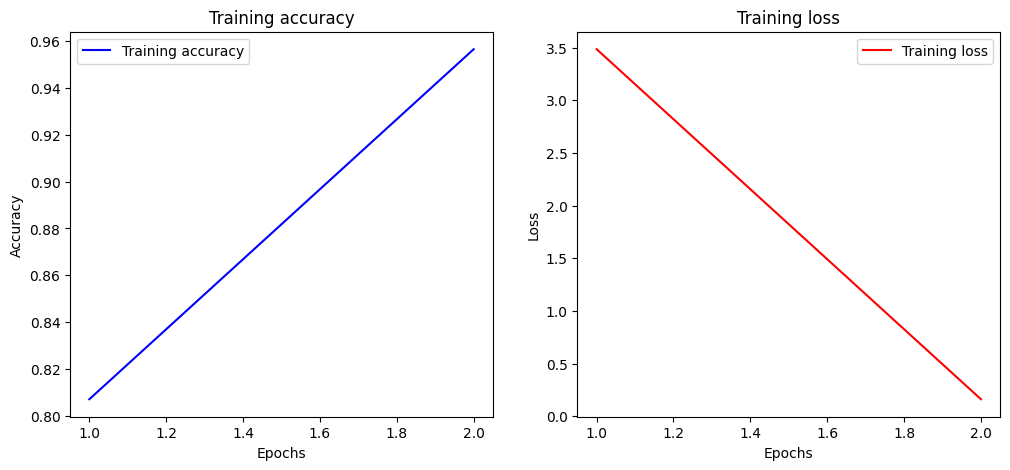

In [ ]:
# acc is from 0.8070312738418579 to 0.9565704464912415
# loss 3.484376907348633 to 0.16174615919589996

pos_hist = np.array([0.8070312738418579, 0.9565704464912415])
pos_loss = np.array([3.484376907348633, 0.16174615919589996])

history = {
    'accuracy': pos_hist,
    'loss': pos_loss
}
plot_history(history)

In [ ]:
model_url = "https://drive.google.com/file/d/10s4jexprW6F22MXY8WnHssBva0UwRgQy/view?usp=sharing"
output_path = "sign_language_model_v2_finetune_newdata.keras"
gdown.download(model_url, output_path, quiet=True, fuzzy=True, use_cookies=False)
model = tf.keras.models.load_model('sign_language_model_v2_finetune_newdata.keras')

In [ ]:
model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.0635 - loss: 7.4236


[7.38428258895874, 0.06735751032829285]

In [ ]:
# create custom callback on batch end to clear the memory
import gc
class ClearMemory(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

In [ ]:
model = tf.keras.models.load_model('sign_language_model_v2_finetune_newdata.keras')
for layer in model.layers[:-3]:  # Freeze all layers except the last n number
    layer.trainable = False
# train_asl = train_asl.prefetch(buffer_size=tf.data.AUTOTUNE)
with tf.device('/GPU:0'):
  history = model.fit(
      train_asl,
      validation_data = test_dataset,
      epochs=1,
      callbacks=[ClearMemory()]
  )
model.save('sign_language_model_v3_finetune_newdata.keras')

 453/1743 ━━━━━━━━━━━━━━━━━━━━ 1:36:15 4s/step - accuracy: 0.9808 - loss: 0.0602

In [ ]:
plot_history(history)
# save history
import json

# # Save the history
with open('history_nerb3.json', 'w') as f:
    json.dump(history, f)

## Evaluation

In [ ]:
import gdown
url = "https://drive.google.com/file/d/1s4_UK_3TX7dM1laFXWjY1I8EtFpkP-PF/view?usp=sharing"
output_path = 'test.zip'
# download zip test from drive
gdown.download(url, output_path, quiet=True, fuzzy=True, use_cookies=False)

'test.zip'

In [ ]:
# unzip
!unzip test.zip

Archive:  test.zip
  inflating: test/P/IMG_20241130_113009.jpg  
  inflating: test/P/IMG_20241130_112839.jpg  
  inflating: test/P/IMG_20241130_112854.jpg  
  inflating: test/P/IMG_20241130_113001.jpg  
  inflating: test/P/IMG_20241130_112847.jpg  
  inflating: test/P/IMG_20241130_112832.jpg  
  inflating: test/P/IMG_20241130_112942.jpg  
  inflating: test/P/IMG_20241130_112930.jpg  
  inflating: test/P/IMG_20241130_112931_1.jpg  
  inflating: test/P/IMG_20241130_113012.jpg  
  inflating: test/P/IMG_20241130_112831.jpg  
  inflating: test/P/IMG_20241130_112959.jpg  
  inflating: test/P/IMG_20241130_112846.jpg  
  inflating: test/P/IMG_20241130_112948.jpg  
  inflating: test/nothing/IMG_20241130_120240.jpg  
  inflating: test/P/IMG_20241130_112853.jpg  
  inflating: test/P/IMG_20241130_112906.jpg  
  inflating: test/P/IMG_20241130_112840.jpg  
  inflating: test/P/IMG_20241130_112940.jpg  
  inflating: test/P/IMG_20241130_112949.jpg  
  inflating: test/P/IMG_20241130_112905.jpg  
  infla

In [ ]:
test_dataset, _ = load_datasets('test', img_width=128, img_height=128, batch_size=256)

Found 579 files belonging to 29 classes.


In [ ]:
model_url = "https://drive.google.com/file/d/10s4jexprW6F22MXY8WnHssBva0UwRgQy/view?usp=sharing"
output_path = "sign_language_model_v2_finetune_newdata.keras"
gdown.download(model_url, output_path, quiet=True, fuzzy=True, use_cookies=False)
model = tf.keras.models.load_model('sign_language_model_v2_finetune_newdata.keras')

In [ ]:
# evaluate
model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.0683 - loss: 7.3505


[7.38428258895874, 0.06735751032829285]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: G (L.jpg)


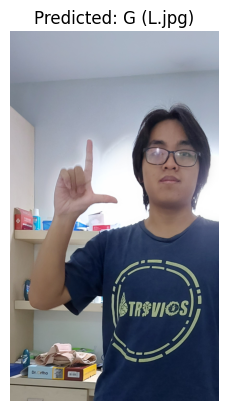

('G', 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted: G (W.jpg)


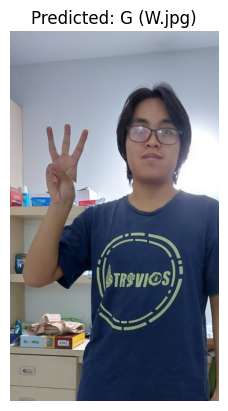

('G', 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted: space (L2.png)


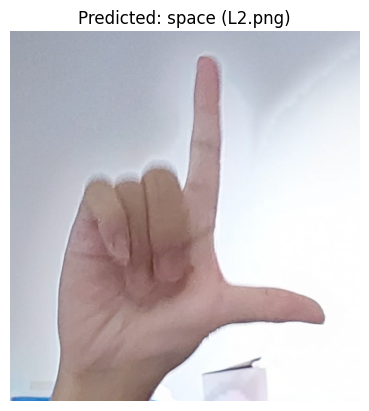

('space', 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted: W (we.png)


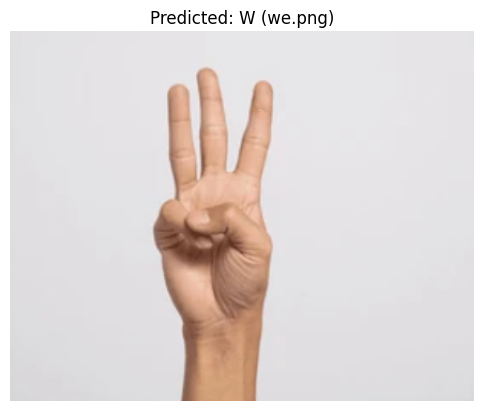

('W', 22)


In [ ]:
# path = "test/A/.jpg"
# print(predict_image_class(path, model, class_names, True))
# print()
path = "L.jpg"
print(predict_image_class(path, model, class_names, True))
print()
path = "W.jpg"
print(predict_image_class(path, model, class_names, True))
print()
path = "L2.png" # ini setelah di zoom
print(predict_image_class(path, model, class_names, True))
print()
path = "we.png"
print(predict_image_class(path, model, class_names, True))